#### Directories etc

In [3]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm import tqdm
from Comparative_Analysis import Utilities as util
from collections import defaultdict
import random
from joblib import Parallel, delayed
from Comparative_Analysis import Blast_Functions as blastfn
import time
import re
import os
import copy
from Comparative_Analysis import ORF_Functions as orffn
from random import sample
pd.options.mode.chained_assignment = None  # default='warn'
import ete3
import matplotlib.pyplot as plt
from statistics import mode, median

C:\Users\nicho\Anaconda3\envs\Bioinformatics\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\nicho\Anaconda3\envs\Bioinformatics\lib\site-packages\ete3-3.1.2-py3.7.egg\ete3\evol\parser\codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


In [4]:
project_dir = 'F:/Project_Data/Project_11'
seq_dir = 'F:/Datasets/Actinobacteria_Ref_Rep_Lev_Complete'
dictionary_dir = 'F:/Datasets/CRYPTIC_DATA/Cryptic_Dictionaries'
tb_species = 'NC_000962.3' 
tb_genome_filename = 'GCF_000195955.2_ASM19595v2_genomic.gbff'
mycobrowser_dir = 'F:/Datasets/Data_From_Publications'
num_cores = 16
core_numbers = list(range(1, num_cores+1))

In [5]:
with open(project_dir + '/Thoth_Full_Run/position_dict.pkl', 'rb') as f:
    full_sample_position_dict = pickle.load(f)  
with open(project_dir + '/Thoth_Full_Run/variant_df.pkl', 'rb') as f:
    full_variant_df = pickle.load(f)   
with open(project_dir + '/gpi_variant_df.pkl', 'rb') as f:
    gpi_variant_df = pickle.load(f) 

In [6]:
for record in SeqIO.parse(seq_dir + '/' + tb_genome_filename, "genbank"):
    full_sequence = str(record.seq)

In [7]:
with open(project_dir + '/Mutation_Counts/zero_and_non_zero_mutation_counts.pkl', 'rb') as f:
    gpi_zero_and_non_zero_mutation_counts = pickle.load(f)     
with open(project_dir + '/Thoth_Full_Run/zero_and_non_zero_mutation_counts.pkl', 'rb') as f:
    full_sample_zero_and_non_zero_mutation_counts = pickle.load(f)   

In [8]:
genomes_df = pd.read_csv('F:/Project_Data/Project_11/Datasets/GENOMES.csv');


C:\Users\nicho\AppData\Local\Temp/ipykernel_34172/796550937.py:1: DtypeWarning: Columns (1,3,13,14,15,27,36) have mixed types. Specify dtype option on import or set low_memory=False.
  genomes_df = pd.read_csv('F:/Project_Data/Project_11/Datasets/GENOMES.csv');


In [9]:
compass_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/COMPASS.csv', names = ['species', 'start', 'stop','count'])
compass_dict = {}
for i, r in compass_df.iterrows():
    for k in range(r['start'], r['stop']):     #  Should te start-1 but seems to ve inconsistency with mutations!!
        compass_dict[k] = 'Y'

##### Plot p values for known CDS

In [10]:
annotation_cds_boundaries = []
for genome_record in SeqIO.parse(seq_dir + '/' + tb_genome_filename, "genbank"):
    for feature in genome_record.features:
        if feature.type == 'CDS':
            a = feature.qualifiers  
            annotation_cds_boundaries.append((a.get("locus_tag")[0], a.get("product")[0], int(feature.location.start), int(feature.location.end), int(feature.location.strand)))   

In [11]:
mycobrowser_df = pd.read_excel(mycobrowser_dir+'/Mycobrowser_Release_4.xlsx')
temp_cds = mycobrowser_df[mycobrowser_df['Feature'] == 'CDS'][['Locus','Start','Stop','Strand','Product','Name','Functional_Category','Gene Ontology']]      #Just CDS
mycobrowser_cds_boundaries = []
for i, r in temp_cds.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    mycobrowser_cds_boundaries.append((r['Locus'],r['Product'], r['Start']-1, r['Stop'], strand, r['Name'], r['Functional_Category'], r['Gene Ontology']))
mycobrowser_cds_boundaries.sort(key = lambda x: x[2])

temp_cds = mycobrowser_df[mycobrowser_df['Feature'].isin(['CDS','rRNA','tRNA'])][['Locus','Start','Stop','Strand','Product','Name','Functional_Category','Gene Ontology']]      #Just CDS
mycobrowser_all_boundaries = []
for i, r in temp_cds.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    mycobrowser_all_boundaries.append((r['Locus'],r['Product'], r['Start']-1, r['Stop'], strand, r['Name'], r['Functional_Category'], r['Gene Ontology']))
mycobrowser_all_boundaries.sort(key = lambda x: x[2])

In [13]:
min_intergenic_length = 50
mycobrowser_interregion_boundaries = []
max_stop = 0
for n,cds in enumerate(mycobrowser_all_boundaries):
    stop = cds[3]
    max_stop = max(stop, max_stop)
    if n < len(mycobrowser_all_boundaries) - 1:
        if mycobrowser_all_boundaries[n+1][2] > max_stop + min_intergenic_length:
            mycobrowser_interregion_boundaries.append((cds[0], cds[1], max_stop, mycobrowser_all_boundaries[n+1][2], cds[4], cds[5]))


In [ ]:
min_intergenic_length = 50
candidate_intergenic_orfs = []
max_stop = 0
ORFFinder = orffn.ORF_Finder(full_sequence)
for n,cds in enumerate(mycobrowser_all_boundaries):
    stop = cds[3]
    max_stop = max(stop, max_stop)
    if n < len(mycobrowser_all_boundaries) - 1:
        if mycobrowser_all_boundaries[n+1][2] > max_stop + min_intergenic_length:
            a =ORFFinder.max_orf(max_stop, mycobrowser_all_boundaries[n+1][2], output_orfs = 'Nested', min_orf_length = 50)
            for x in a:
                candidate_intergenic_orfs.append(x)
            

In [19]:
def bin_formula(position_3_counts, tot_bin_counts):
    return 1- binom.cdf(position_3_counts-1, tot_bin_counts,1/3)
def mutation_bin_probability(mutation_counts):
    bin_counts = [0,0,0]
    for i, c in enumerate(mutation_counts):
        bin_counts[i % 3] += min(c,20000000)
    if sum(bin_counts) == 0:
        return (bin_counts, 2)
    else:
        return (bin_counts, bin_formula(bin_counts[2], sum(bin_counts)))  

In [15]:
p =sum([1 for x in full_sample_zero_and_non_zero_mutation_counts if x > 0])/(len(full_sequence) - len(compass_dict))
print(p)
def conf_interval(n):
    return math.sqrt(p*(1-p))/math.sqrt(n)

0.48730925587553936


In [16]:
locus_mutation_ave = []
scores =[]
hi_mutation_scores = []
lo_mutation_scores = []
total_mutation_count = []
hi_mutation_threshold = 1000
for (locus, product, start, stop, strand, name, functional_category, gene_ontology) in mycobrowser_cds_boundaries: #interregion_boundaries:
    compass_overlap = 0
    for n in range(start, stop):
        if n in compass_dict:
            compass_overlap += 1
    if compass_overlap / (stop - start) > 0.1:
        continue
    mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start+3:stop-3]
    max_mutation_counts = max(mutation_counts)
    total_mutation_count.append(sum(mutation_counts))
    if strand == 1:
        scores.append(mutation_bin_probability(mutation_counts)[1])
        if max_mutation_counts > hi_mutation_threshold:
            hi_mutation_scores.append(mutation_bin_probability(mutation_counts)[1])
        if max_mutation_counts <= hi_mutation_threshold:
            lo_mutation_scores.append(mutation_bin_probability(mutation_counts)[1])
    else:
        scores.append(mutation_bin_probability(reversed(mutation_counts))[1])
        if max_mutation_counts > hi_mutation_threshold:
            hi_mutation_scores.append(mutation_bin_probability(reversed(mutation_counts))[1])
        if max_mutation_counts <= hi_mutation_threshold:
            lo_mutation_scores.append(mutation_bin_probability(reversed(mutation_counts))[1])
    proportion_mutated_positions = sum([1 for m in mutation_counts if m>0])/len(mutation_counts)
    length = len(mutation_counts)
    num_sds = (proportion_mutated_positions - p)/conf_interval(length)
    if (abs(num_sds)> 4):
        locus_class = 'X'
    else:
        locus_class = 'N'
    locus_mutation_ave.append([locus, name, product, sum(mutation_counts)/len(mutation_counts), max(mutation_counts), median(mutation_counts), start, stop, strand, 
                               len(mutation_counts), proportion_mutated_positions, num_sds, locus_class, functional_category, gene_ontology])
locus_mutation_ave.sort(key = lambda x:x[3])

In [185]:
locus_mutation_ave_df = pd.DataFrame(locus_mutation_ave, columns = ['locus','name','product','ave_mutation','max_mutation','median_mutation','start','stop','strand',
                                                                    'length','ave_pos','num_sds','locus_class', 'functional_category', 'gene_ontology'])

In [186]:
len(locus_mutation_ave_df)

3703

In [187]:
len(list(locus_mutation_ave_df['locus'].unique()))

3703

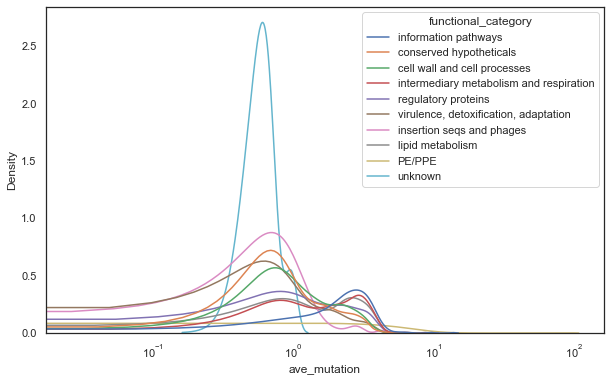

In [217]:
sns.set(rc={"figure.figsize": (10, 6)})
sns.set_style(style='white')
sns.kdeplot(data = locus_mutation_ave_df, x= 'ave_mutation', hue = 'functional_category', common_norm= False,clip=(0.0, 1000000000.0))
plt.xscale('log')

<AxesSubplot:ylabel='Count'>

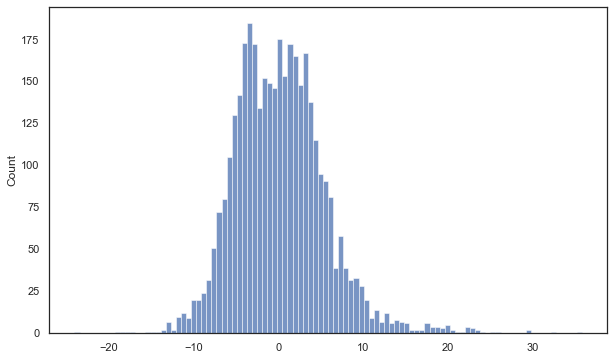

In [317]:
sns.histplot([x[11] for x in locus_mutation_ave], bins=100)

In [329]:
consecutive_table = []
consecutives = 0
temp = []
locus_mutation_ave.sort(key = lambda x:x[6])
for x in locus_mutation_ave:
    if (x[11]) < -6:
        temp.append((x,int(re.sub('[^0-9]','', x[0]))))
for i in range(len(temp)-1):
    if temp[i+1][1] - temp[i][1] < 2:
        consecutive_table.append([temp[i][0][0], temp[i][0][2], temp[i+1][0][0], temp[i+1][0][2]])
        consecutives+=1
pd.DataFrame(consecutive_table, columns = ['Locus','Function','Adjacent_Locus','Adjacent_Locus_Function']).to_csv(project_dir + '/adjacent_high_conserved_genes.csv')
print(len(temp), consecutives)

365 84


<AxesSubplot:ylabel='Proportion'>

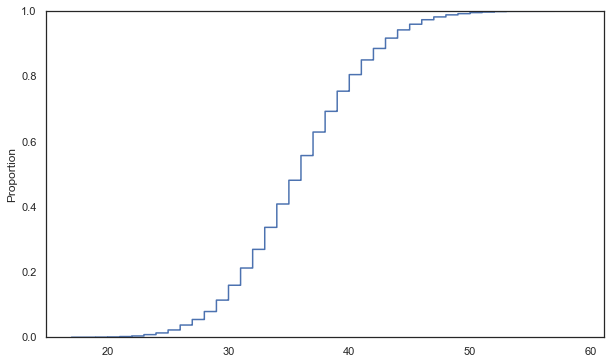

In [325]:
nsims = 10000
nconsecutives = []
for n in range(nsims):
    consecutives = 0
    a = random.sample(range(3703), 365)
    a.sort()
    for i in range(len(a)-1):
        if a[i+1] - a[i] < 2:
            consecutives+=1
    nconsecutives.append(consecutives)
sns.ecdfplot(nconsecutives)

In [328]:
nconsecutives.sort()
nconsecutives[int(len(nconsecutives)*0.99)]

49

In [201]:
locus_mutation_ave_df[abs(locus_mutation_ave_df['num_sds'])>10].to_csv(project_dir + '/conserved_genes_many_consecutive.csv')

In [ ]:
a=[x for x in locus_mutation_ave if x[11] > 15]
a.sort(key = lambda x: x[0])
for x in a:
    print(x)

<AxesSubplot:xlabel='length', ylabel='ave_pos'>

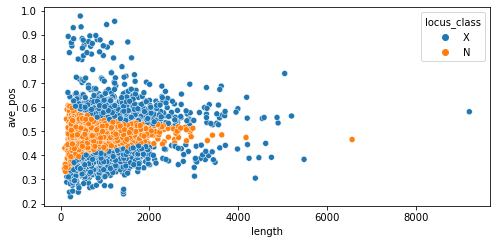

In [229]:
sns.scatterplot(data = locus_mutation_ave_df, x = 'length', y = 'ave_pos', hue = 'locus_class')

<AxesSubplot:xlabel='length', ylabel='proportion'>

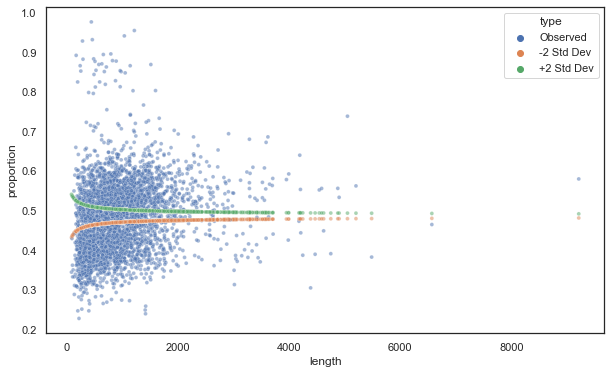

In [119]:
temp = []
for i, r in locus_mutation_ave_df.iterrows():
    temp.append([r['length'], r['ave_pos'],'Observed'])
    temp.append([r['length'], p - conf_interval(r['length']), '-2 Std Dev'])
    temp.append([r['length'], p + conf_interval(r['length']), '+2 Std Dev'])
temp_df = pd.DataFrame(temp, columns = ['length','proportion','type'])
sns.set(rc={"figure.figsize": (10, 6)})
sns.set_style(style='white')
sns.scatterplot(data = temp_df, x = 'length', y = 'proportion', hue = 'type', s =15, alpha=0.5)

[Text(0.5, 0, 'P-value'), Text(0, 0.5, 'Count'), Text(0.5, 1.0, '')]

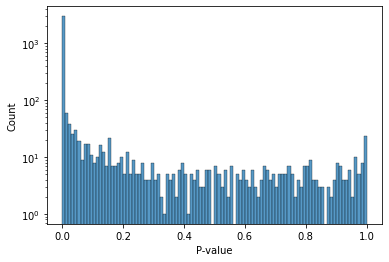

In [20]:
plt=sns.histplot(scores, bins = 100, log_scale=(False,True))
#plt.yscale('log')
plt.set(xlabel ="P-value", ylabel = "Count", title ='')

[Text(0.5, 0, 'P-value'),
 Text(0, 0.5, 'Cumulative Proportion'),
 Text(0.5, 1.0, '')]

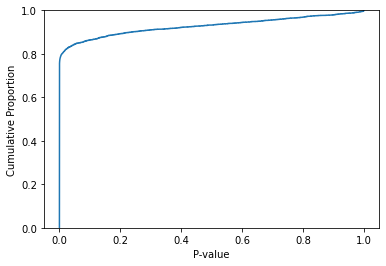

In [21]:
plt = sns.ecdfplot(scores)
plt.set(xlabel ="P-value", ylabel = "Cumulative Proportion", title ='')

[Text(0.5, 17.200000000000003, 'P-value'),
 Text(17.246874999999996, 0.5, 'Cumulative Proportion'),
 Text(0.5, 1.0, '')]

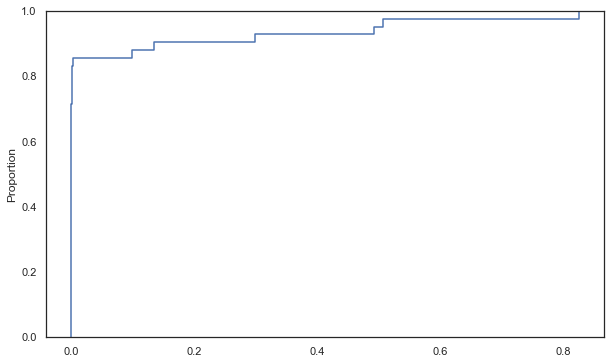

In [260]:
sns.ecdfplot(hi_mutation_scores)
plt.set(xlabel ="P-value", ylabel = "Cumulative Proportion", title ='')

C:\Users\nicho\AppData\Local\Temp/ipykernel_31416/2171414875.py:3: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


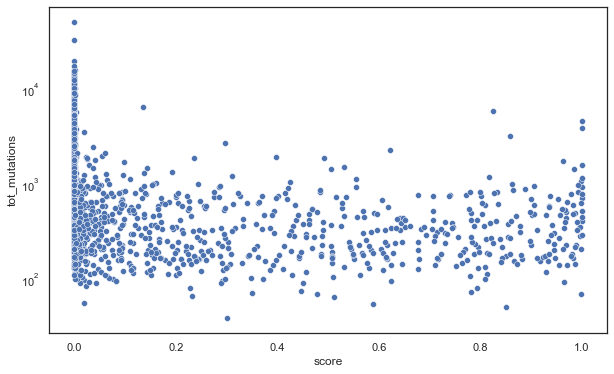

In [263]:
temp = pd.DataFrame(zip(scores, total_mutation_count), columns = ['score','tot_mutations'])
sns.scatterplot(data = temp, x = 'score', y = 'tot_mutations')
plt.yscale('Log')

In [26]:
filtered_intergenic_orfs = []
temp =[]
for (start, stop, strand, length) in candidate_intergenic_orfs:
    compass_overlap = 0
    for n in range(start, stop):
        if n in compass_dict:
            compass_overlap += 1
    if compass_overlap / (stop - start) > 0.2:
        continue
    if strand == 1:
        prob = mutation_bin_probability(full_sample_zero_and_non_zero_mutation_counts[start:stop])
    else:
        prob = mutation_bin_probability(reversed(full_sample_zero_and_non_zero_mutation_counts[start:stop]))
    temp.append(prob)
    if prob[1] < 0.01:
        filtered_intergenic_orfs.append((start, stop, strand, length, prob[1]))
scores = []
for x in temp:
    scores.append(x[1])

NameError: name 'candidate_intergenic_orfs' is not defined

In [ ]:
len(scores)

In [ ]:
sns.histplot(scores, bins = 100)

In [ ]:
filtered_intergenic_orfs[0:3]

#### Produce FASTA file with CDS candidates

In [ ]:
seq_dir = 'F:/Datasets/Actinobacteria_Ref_Rep_Lev_Complete'
sample_filenames = ['GCF_000195955.2_ASM19595v2_genomic.gbff', 'GCF_024600175.1_ASM2460017v1_genomic.gbff', 'GCF_010730055.1_ASM1073005v1_genomic.gbff', 'GCF_020616615.1_ASM2061661v1_genomic.gbff', 'GCF_010731535.1_ASM1073153v1_genomic.gbff',
                    'GCF_022370755.1_ASM2237075v1_genomic.gbff', 'GCF_016745295.1_ASM1674529v1_genomic.gbff', 'GCF_000157895.3_ASM15789v2_genomic.gbff', 'GCF_900603025.1_MHAS_genomic.gbff', 'GCF_018363015.1_ASM1836301v1_genomic.gbff',
                    'GCF_019645855.1_ASM1964585v1_genomic.gbff', 'GCF_010727945.1_ASM1072794v1_genomic.gbff', 'GCF_010731895.1_ASM1073189v1_genomic.gbff', 'GCF_900637205.1_50279_G01_genomic.gbff', 'GCF_000184435.1_ASM18443v1_genomic.gbff']
organism_name_dict = {}
for filename in tqdm(sample_filenames):
    record = next(SeqIO.parse(seq_dir + '/' + filename, "genbank"))
    organism_name = record.annotations['organism']
    accession_ver = record.annotations['accessions'][0] + '.' + str(record.annotations['sequence_version'])
    organism_name_dict[accession_ver] = organism_name

In [ ]:
trans = util.Translator()

In [ ]:
temp = []

for x in filtered_intergenic_orfs:
    prot = trans.translate_sequence(full_sequence[x[0]:x[1]], x[2], 0)
    name = 'NC_000962.3@'+str(x[0])+'_'+str(x[1])
    temp.append([name, prot[:-1]])
util.produce_fasta_file(temp, project_dir + '/filtered_intergenic_proteins.faa')

In [ ]:
#blastfn.build_blast_db(project_dir, 'comparator_orfs.fasta', 'comparator_orfs', 'F:/Datasets/BLAST/comparator_orfs')
#blastfn.build_blast_db(project_dir, 'mycobrowser_inter_feature_orfs.fasta', 'mycobrowser_inter_feature_orfs', 'F:/Datasets/BLAST/mycobrowser_inter_feature_orfs')

In [ ]:
blastfn.run_blastp('F:/Datasets/BLAST/comparator_orfs', 'filtered_intergenic_proteins.faa', 'comparator_orfs', 'filtered_intergenic_hits.csv', e_value = 0.001)

In [ ]:
blast_output = blastfn.process_blast_output('F:/Datasets/BLAST/comparator_orfs/filtered_intergenic_hits.csv', organism_name_dict, top_hit_only = False)

In [ ]:
blast_output.to_csv(project_dir + '/filtered_intergenic_blast_output.csv')

#### Look at mutation rate overdispersion

In [ ]:
trans.translate_sequence(full_sequence[2405354:2405486],-1,0)

In [11]:
mutation_bin_probability(reversed(full_sample_zero_and_non_zero_mutation_counts[908014:908113]))
#mutation_bin_probability((full_sample_zero_and_non_zero_mutation_counts[1232176:1232293]))

([93, 40, 155], 7.390754674929667e-13)

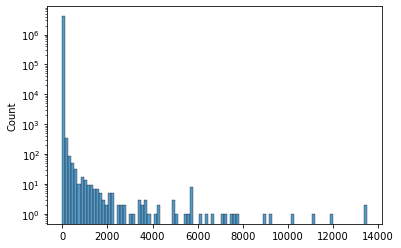

In [69]:
amended_mutation_counts = []
for n, c in enumerate(full_sample_zero_and_non_zero_mutation_counts):
    if n in compass_dict:
        continue
    else:
        amended_mutation_counts.append(c)
pd.DataFrame(amended_mutation_counts).to_csv(project_dir + '/R_amended_mutation_counts.csv')
sns.histplot([x for x in amended_mutation_counts], bins = 100)
plt.yscale('log')

In [ ]:
for n, c in enumerate(full_sample_zero_and_non_zero_mutation_counts):
    if c>8000 and c< 100000:
        position_info = full_sample_position_dict[n+1]
        substitutions = [x[1] for x in position_info[1:]]
        source = full_sequence[n-1:n+2]
        destination = full_sequence[n-1] + mode(substitutions).upper() + full_sequence[n+1]
        print(n, c, full_sequence[n-1:n+2], position_info[0], mode(substitutions), source, destination)

In [ ]:
len(full_sample_position_dict[836538])

In [ ]:
temp = []
for n, c in enumerate(zero_and_non_zero_mutation_counts):
    if n in compass_dict:
        temp.append(c)
pd.DataFrame(temp).to_csv(project_dir + '/R_amended_mutation_counts.csv')

In [ ]:
for k, v in compass_dict.items():
    if not(full_sample_zero_and_non_zero_mutation_counts[k] ==0):
        print(k, full_sample_zero_and_non_zero_mutation_counts[k])

In [ ]:
pd.DataFrame(full_sample_zero_and_non_zero_mutation_counts).to_csv(project_dir + '/R_mutation_counts.csv')

#####  Tree mutation plots for output displays in R

In [303]:
with open(project_dir + '/id_dict.pkl', 'rb') as f:
    ids = pickle.load(f)   
id_reverse_dict = {}
for k, v in ids.items():
    id_reverse_dict[v] = k

In [308]:
with open(project_dir + '/pos_id_dict.pkl', 'rb') as f:
    pos_id_dict = pickle.load(f)   

In [304]:
lineage_dict = {}
for i,r in genomes_df.iterrows():
    lineage_dict[r['UNIQUEID']] = r['MYKROBE_LINEAGE_NAME_1'] 

In [309]:
with open(project_dir + '/Dictionaries/variant_dictionary_364848_365376_.pkl', 'rb') as f:
        var_dict = pickle.load(f)  
with open(project_dir + '/Mutation_Counts/mutation_counts_364848_365376_.pkl', 'rb') as f:
        mutation_counts = pickle.load(f)  
temp_dict = {}
for k, v in var_dict.items():
    if not(v[pos_id_dict[3186859] - 364848] =={'T'}):
        temp_dict[k] =list(v[pos_id_dict[3186859] - 364848])[0]

In [ ]:
with open(project_dir + '/Dictionaries/variant_dictionary_331584_332112_.pkl', 'rb') as f:
        var_dict = pickle.load(f)  
with open(project_dir + '/Mutation_Counts/mutation_counts_331584_332112_.pkl', 'rb') as f:
        mutation_counts = pickle.load(f)  
temp_dict = {}
for k, v in var_dict.items():
    if not(v[pos_id_dict[2878549] - 331584] =={'G'}):
        temp_dict[k] =list(v[pos_id_dict[2878549] - 331584])[0]

In [310]:
tb_tree_filename = 'tb_gpi.nwk'
master_tree2= ete3.Tree(project_dir + '/' + tb_tree_filename)
for node in master_tree2.traverse("postorder"):
    if node.is_leaf():
        if node.name in temp_dict:
            node.name = str(lineage_dict[id_reverse_dict[int(node.name.split('_')[1])]]) + '_'+temp_dict[(node.name)]
            nstyle = ete3.NodeStyle()
            nstyle["fgcolor"] = "red"
            nstyle["size"] = 1
            node.set_style(nstyle)
        else:
            node.name = str(lineage_dict[id_reverse_dict[int(node.name.split('_')[1])]])

In [313]:
ts = ete3.TreeStyle()
ts.mode = 'c'

In [314]:
master_tree2.render(project_dir+'/mytree.pdf', tree_style=ts);

In [305]:
tb_tree_filename = 'tb_gpi.nwk'
master_tree2= ete3.Tree(project_dir + '/' + tb_tree_filename)
temp = []
for node in master_tree2.traverse("postorder"):
    if node.is_leaf():
        temp.append([node.name, lineage_dict[id_reverse_dict[int(node.name.split('_')[1])]]])
temp_df = pd.DataFrame(temp, columns = [['label', 'lineage']])
temp_df.to_csv(project_dir + '/lineages.csv')

##### Analyse mutation counts

In [32]:
full_sample_variant_count_dict = {}
full_sample_variant_counts = full_variant_df.groupby(['GENOME_INDEX'])['UNIQUEID'].count().reset_index()
for i, r in full_sample_variant_counts.iterrows():
    full_sample_variant_count_dict[r['GENOME_INDEX']-1] = r['UNIQUEID']

In [33]:
gpi_variant_count_dict = {}
gpi_variant_counts = gpi_variant_df.groupby(['GENOME_INDEX'])['UNIQUEID'].count().reset_index()
for i, r in gpi_variant_counts.iterrows():
    gpi_variant_count_dict[r['GENOME_INDEX']-1] = r['UNIQUEID']

Text(0.5, 0, 'Number of mutations')

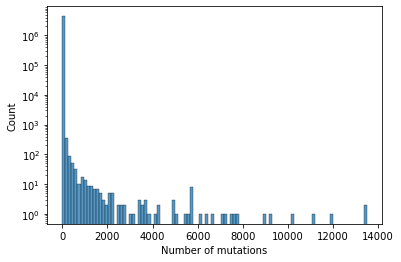

In [70]:
a=full_sample_zero_and_non_zero_mutation_counts
b=[x for x in a if x>-1]
sns.histplot(b, bins=100)
plt.yscale('log')
plt.xlabel('Number of mutations')

Text(0.5, 0, 'Number of mutations')

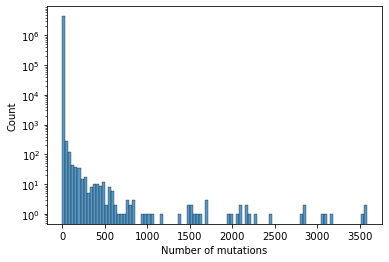

In [71]:
a=gpi_zero_and_non_zero_mutation_counts
b=[x for x in a if x>-1]
sns.histplot(b, bins=100)
plt.yscale('log')
plt.xlabel('Number of mutations')

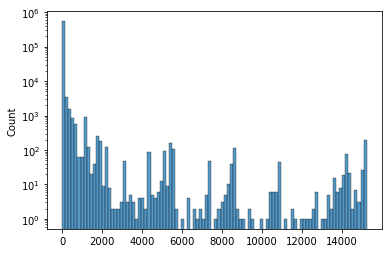

In [34]:
a=gpi_variant_count_dict.values()
b=[x for x in a if x>-1]
sns.histplot(b, bins=100)
plt.yscale('log')

##### Analyse total mutations v parsimonious mutations to define threshold for highly mutated and output table

<AxesSubplot:xlabel='Total_Mutations', ylabel='Minimum_Mutations'>

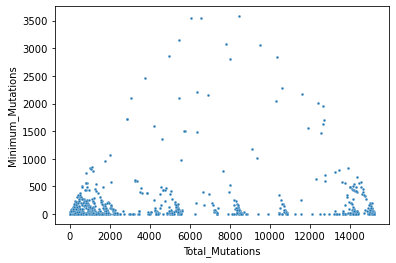

In [72]:
total_mutation_counts = []
for i in range(len(gpi_zero_and_non_zero_mutation_counts)):
    if i in gpi_variant_count_dict:
        total_mutation_counts.append(gpi_variant_count_dict[i])
    else:
        total_mutation_counts.append(0)
consistency_df = pd.DataFrame(zip(gpi_zero_and_non_zero_mutation_counts, total_mutation_counts), columns = ['Minimum_Mutations', 'Total_Mutations'])
sns.scatterplot(data = consistency_df, x = 'Total_Mutations', y = 'Minimum_Mutations', s = 7)

<AxesSubplot:xlabel='Total_Mutations', ylabel='Minimum_Mutations'>

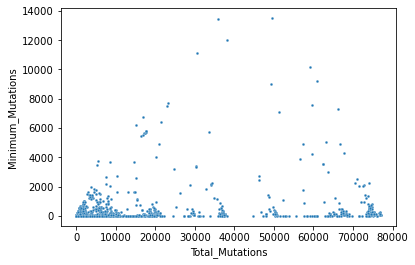

In [73]:
total_mutation_counts = []
for i in range(len(full_sample_zero_and_non_zero_mutation_counts)):
    if i in full_sample_variant_count_dict:
        total_mutation_counts.append(full_sample_variant_count_dict[i])
    else:
        total_mutation_counts.append(0)
consistency_df = pd.DataFrame(zip(full_sample_zero_and_non_zero_mutation_counts, total_mutation_counts), columns = ['Minimum_Mutations', 'Total_Mutations'])
sns.scatterplot(data = consistency_df, x = 'Total_Mutations', y = 'Minimum_Mutations', s =7)

In [80]:
temp = []
for n, c in enumerate(full_sample_zero_and_non_zero_mutation_counts):
    if c > 2000:
        temp.append(n)
temp_2_dict = {}
for i in temp:
    found = 0
    for (locus, product, start, stop, strand, name) in mycobrowser_cds_boundaries:
        if i >= start and i < stop:
            if name in temp_2_dict:
                temp_2_dict[name].append(str(i))
            else:
                temp_2_dict[name] = [str(i)]
            found = 1
            break
    if found == 0:
        if 'intergenic' in temp_2_dict:
            temp_2_dict['intergenic'].append(str(i))
        else:
            temp_2_dict['intergenic'] = [str(i)]
temp = []
for k, v in temp_2_dict.items():
    temp.append([k, '  '.join(v)])
pd.DataFrame(temp, columns = ['Gene', 'Positions (zero indexed)']).to_csv(project_dir + '/High_Mutation_Positions.csv')

##### Analyse high/low mutations in intergenic regions

In [283]:
intergenic_mutation_ave = []
scores =[]
for (locus, product, start, stop, strand, name) in mycobrowser_interregion_boundaries:
    compass_overlap = 0
    for n in range(start, stop):
        if n in compass_dict:
            compass_overlap += 1
    if compass_overlap / (stop - start) > 0.1:
        continue
    mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:stop]
    if strand == 1:
        scores.append(mutation_bin_probability(mutation_counts)[1])
    else:
        scores.append(mutation_bin_probability(reversed(mutation_counts))[1])
    proportion_mutated_positions = sum([1 for m in mutation_counts if m>0])/len(mutation_counts)
    length = len(mutation_counts)
    num_sds = (proportion_mutated_positions - p)/conf_interval(length)
    if (abs(num_sds)> 4):
        locus_class = 'X'
    else:
        locus_class = 'N'
    intergenic_mutation_ave.append([locus, name, product, sum(mutation_counts)/len(mutation_counts), max(mutation_counts), median(mutation_counts), start, stop, strand, 
                               len(mutation_counts), proportion_mutated_positions, num_sds, locus_class, compass_overlap/(stop-start)])
intergenic_mutation_ave.sort(key = lambda x:x[3])

In [284]:
intergenic_mutation_ave_df = pd.DataFrame(intergenic_mutation_ave, columns = ['locus','name','product','ave_mutation','max_mutation','median_mutation','start','stop','strand',
                                                                    'length','ave_pos','num_sds','locus_class', 'compass_overlap'
                                                                             ])

<AxesSubplot:xlabel='ave_mutation', ylabel='Count'>

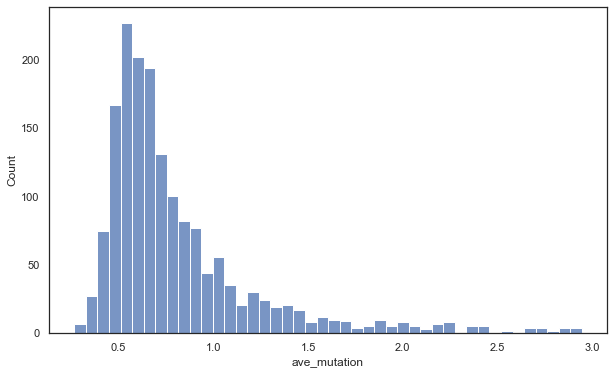

In [294]:
sns.histplot(data = intergenic_mutation_ave_df[intergenic_mutation_ave_df['ave_mutation'] < 3], x = 'ave_mutation')

<AxesSubplot:xlabel='length', ylabel='proportion'>

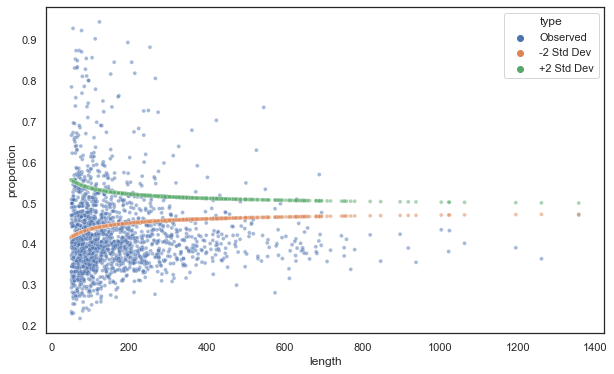

In [285]:
temp = []
for i, r in intergenic_mutation_ave_df.iterrows():
    temp.append([r['length'], r['ave_pos'],'Observed'])
    temp.append([r['length'], p - conf_interval(r['length']), '-2 Std Dev'])
    temp.append([r['length'], p + conf_interval(r['length']), '+2 Std Dev'])
temp_df = pd.DataFrame(temp, columns = ['length','proportion','type'])
sns.set(rc={"figure.figsize": (10, 6)})
sns.set_style(style='white')
sns.scatterplot(data = temp_df, x = 'length', y = 'proportion', hue = 'type', s =15, alpha=0.5)

In [295]:
for i, r in intergenic_mutation_ave_df.iterrows():
    if r['ave_mutation'] < 0.3:
        print(r)

locus                                                         Rv1162
name                                                            narH
product            Probable respiratory nitrate reductase (beta c...
ave_mutation                                                0.267857
max_mutation                                                       2
median_mutation                                                  0.0
start                                                        1292741
stop                                                         1292797
strand                                                             1
length                                                            56
ave_pos                                                     0.232143
num_sds                                                    -3.820212
locus_class                                                        N
compass_overlap                                                  0.0
Name: 0, dtype: object
locus      

In [262]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

In [332]:
trans = util.Translator()
len(trans.translate_sequence(full_sequence[2969685:2970084],1,0))

133

In [ ]:
def 